# Problem statement: To generate artificial MRI images of different contrast levels from existing MRI scans using GAN.


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
import imageio
import os
import glob
import shutil
import patoolib


### Importing Dataset

In [2]:
dataset_path = './dataset'

if os.path.exists(dataset_path):
    shutil.rmtree(dataset_path)

if not os.path.isdir(dataset_path):
    os.mkdir(dataset_path)

patoolib.extract_archive('./MRI+T1_T2+Dataset.RAR', outdir=str(dataset_path+'/'))

saved_img_path = './img'
if os.path.exists(saved_img_path):
    shutil.rmtree(saved_img_path)

if not os.path.isdir(saved_img_path):
    os.mkdir(saved_img_path)

checkpoint_path = './Trained_Model'
if os.path.exists(checkpoint_path):
    shutil.rmtree(checkpoint_path)

if not os.path.isdir(checkpoint_path):
    os.mkdir(checkpoint_path)

patool: Extracting ./MRI+T1_T2+Dataset.RAR ...
patool: running "C:\Program Files\WinRAR\rar.EXE" x -- "c:\Users\ADMIN\Downloads\Style Transfer using GAN\MRI+T1_T2+Dataset.RAR"
patool:     with cwd=./dataset/
patool: ... ./MRI+T1_T2+Dataset.RAR extracted to `./dataset/'.


In [3]:
img_ht = 128
img_wt = 128
BATCH_SIZE = 10


In [4]:
# Loading the Dataset
tr1 = tf.keras.preprocessing.image_dataset_from_directory(
  str('./dataset/Tr1'),
  seed=123,
  image_size=(img_ht, img_wt),
  batch_size=BATCH_SIZE,
  label_mode=None,
  shuffle=True,
  color_mode = 'grayscale')

  # Loading the Dataset
tr2 = tf.keras.preprocessing.image_dataset_from_directory(
  str('./dataset/Tr2'),
  seed=123,
  image_size=(img_ht, img_wt),
  batch_size=BATCH_SIZE,
  label_mode=None,
  shuffle=True,
  color_mode = 'grayscale')

Found 43 files belonging to 1 classes.
Found 46 files belonging to 1 classes.


### Data preprocessing:

In [5]:
normalization_layer = tf.keras.layers.Rescaling(1./127.5, offset=-1)
tr1 = tr1.map(lambda x: normalization_layer(x))
tr2 = tr2.map(lambda x: normalization_layer(x))

### Data visualization:

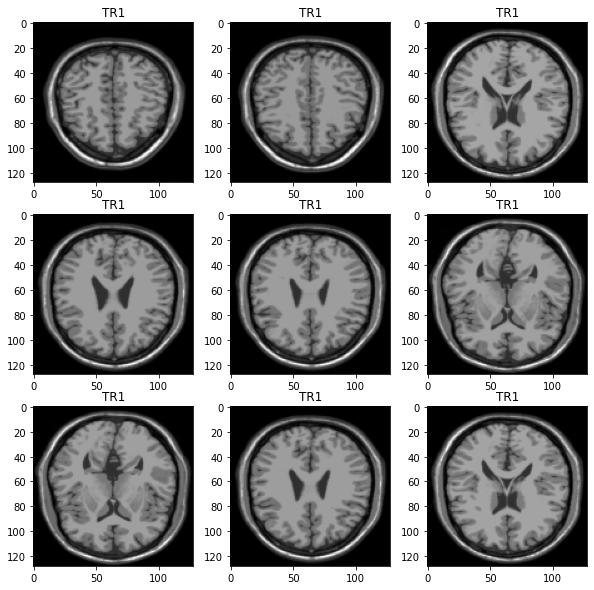

In [6]:
# Visualizing data from T1 dataset 
plt.figure(figsize=(10, 10))
for images in tr1.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i], cmap = 'gray')
    plt.title('TR1')

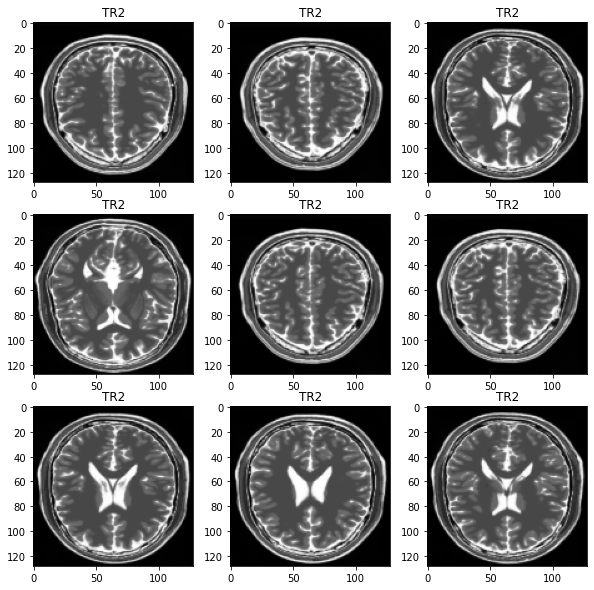

In [7]:
# Visualizing data from T2 dataset 
plt.figure(figsize=(10, 10))
for images in tr2.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i], cmap = 'gray')
    plt.title('TR2')

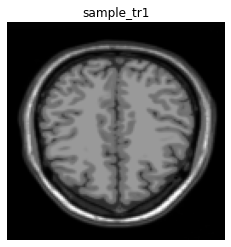

In [8]:
sample_tr1 = next(iter(tr1))
plt.figure(figsize=(4, 4))
plt.imshow(sample_tr1[0].numpy()[:, :, 0], cmap='gray')
plt.title('sample_tr1')
plt.axis('off')
plt.show()

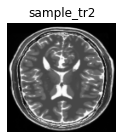

In [9]:
sample_tr2 = next(iter(tr2))
plt.figure(figsize=(2, 2))
plt.imshow(sample_tr2[0].numpy()[:, :, 0], cmap='gray')
plt.title('sample_tr2')
plt.axis('off')
plt.show()

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
Tr1_train = tr1.cache().prefetch(buffer_size=AUTOTUNE)
Tr2_train = tr2.cache().prefetch(buffer_size=AUTOTUNE)

### Model Building
1. Instance Normalization
2. Downsampling, Upsampling and Unet
3. Generator Building using Unet
4. Discriminator Building

#### Instance Normalization
Instance Normalization are specially used with Style Transfer, where Separate Normalization is performed for each sample we perform channelwise Normalization.

In [12]:
class InstanceNormalization(tf.keras.layers.Layer):    
    
    def __init__(self,epsilon=1e-5):
        super().__init__()
        self.epsilon = epsilon

    def build(self,input_shape):
        self.scale = self.add_weight(
            name = 'scale',
            shape = input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name = 'offset',
            shape = input_shape[-1:],
            initializer='zeros',
            trainable=True)
        
    def call(self, x):
        # Compute Mean and Variance, Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

#### Downsampling
Downsampling is performed using the Convolution, leading to reduce in dimensions.

In [13]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Conv2d layer
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    # Add Normalization layer
    if apply_norm:
        result.add(InstanceNormalization())
    # Add Leaky Relu Activation
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [14]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Transposed Conv2d layer
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    # Add Normalization Layer
    result.add(InstanceNormalization())
    # Conditionally add Dropout layer
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    # Add Relu Activation Layer
    result.add(tf.keras.layers.ReLU())
    return result

#### Unets
Unets takes Image as an input and translate it into another Image. <p>
To do this they first use Downsampling on Input Image to learn the latent characteristics of Input Image and then use Upsampling to use this knowledge to Translate it into another Image. <p>

In [15]:
# Unet Generator is a combination of Convolution + Transposed Convolution Layers
def unet_generator():
    down_stack = [
        downsample(64, 4, True), # (bs, 64, 64, 64)
        downsample(128, 4),        # (bs, 32, 32, 128)
        downsample(128, 4),       # (bs, 16, 16, 128)
        downsample(128, 4),       # (bs, 8, 8, 128)
        downsample(256, 4),       # (bs, 4, 4, 256)
        downsample(256, 4),       # (bs, 2, 2, 256)
        downsample(512, 4)        # Bottleneck layer (bs, 1, 1, 512)
    ]
    up_stack = [
        upsample(256, 4, True), # (bs, 2, 2, 256)
        upsample(256, 4, True), # (bs, 4, 4, 256)
        upsample(128, 4), # (bs, 8, 8, 128)
        upsample(128, 4), # (bs, 16, 16, 128)
        upsample(128, 4), # (bs, 32, 32, 128)
        upsample(64, 4)   # (bs, 64, 64, 64)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 128, 128, 1)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[128, 128, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

#### Generator
Generator is a Unet Network here since We want to translate One type of Image (MRI T1) into Another type of Image (MRI T2) or vice versa.

In [16]:
generator_g = unet_generator()
generator_f = unet_generator()

Let's also visualize one of our Generator Models since Both our Generators have same architecture.

In [17]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 64, 64, 64)   1152        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 32, 32, 128)  131328      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 16, 16, 128)  262400      ['sequential_1[0][0]']       

#### Discriminator
Discriminator is a traditional CNN, which we use to classify the Images. Hence it only uses Downsampling .

Both Discriminators have same architecture

In [18]:
# Discriminators only contain Convolutional Layers and no Transposed Convolution is not used 
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    # add input layer of size (128, 128, 1)
    inp = tf.keras.layers.Input(shape=[128, 128, 1], name='input_image')
    x = inp
    
    # add downsampling step here
    down1 = downsample(128, 4, False)(x) # (bs, 64, 64, 128)
    down2 = downsample(128, 4)(down1) # (bs, 32, 32, 128)
    down3 = downsample(256, 4)(down2) # (bs, 16, 16, 256)
    down4 = downsample(512, 4)(down3) # (bs, 8, 8, 512)
    # add a padding layer here
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4) # (bs, 10, 10, 512)
    
    # implement a concrete downsampling layer here
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 7, 7, 512)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    
    # apply zero padding layer
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 9, 9, 512)
    
    # add a last pure 2D Convolution layer
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 6, 6, 1)
    return tf.keras.Model(inputs=inp, outputs=last)

In [19]:
discriminator_x = discriminator()
discriminator_y = discriminator()

In [20]:
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 sequential_26 (Sequential)  (None, 64, 64, 128)       2048      
                                                                 
 sequential_27 (Sequential)  (None, 32, 32, 128)       262400    
                                                                 
 sequential_28 (Sequential)  (None, 16, 16, 256)       524800    
                                                                 
 sequential_29 (Sequential)  (None, 8, 8, 512)         2098176   
                                                                 
 zero_padding2d (ZeroPadding  (None, 10, 10, 512)      0         
 2D)                                                             
                                                           

### Model Training
1. Declare Loss type
2. Calculate Discriminator Loss
3. Calculate Generator Loss
4. Cycle Loss
5. Identity Loss
6. Optimizer
7. Checkpoint Initialization
8. Training Flow

Check output of Untrained Generator models which should be a random noise

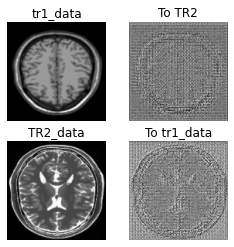

In [21]:
to_TR2 = generator_g(sample_tr1)
to_TR1 = generator_f(sample_tr2)

plt.figure(figsize=(4, 4))

imgs = [sample_tr1, to_TR2, sample_tr2, to_TR1]
title = ['tr1_data', 'To TR2', 'TR2_data', 'To tr1_data']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0].numpy()[:, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

#### Declare Loss as Binary Cross Entropy
Since Our Discriminator is a classifier

In [22]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Discriminator Loss
It consists of two types of losses
1.    Loss on Real Data
2.    Loss on Fake Data

In [23]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5 # mean of losses

#### Generator Loss
It has only one type of loss - Discriminator Loss on Generated data

In [24]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

#### Cycle Loss
When we use both of Generators sequentially on a Input Image, we get Cycle Image and the L1 Loss between these two is called Cycle Loss.

In [25]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss1

#### Identity Loss
When we provide input image to the Generator such that no translation is needed because the Image is already transformed. Here also we take L1 Loss between Input and Output Image.

In [26]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5*loss

#### Optimizer 
We use Adam Optimizer to update weights which is a good optimizer to achieve quick learning.

In [27]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

We'll train out Model for 300 Epochs

In [28]:
EPOCHS = 300

#### Checkpoint Initialization
Initialize checkpoints to save models

In [29]:
checkpoint_path = "./Trained_Model"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Function to show Images output by Generators while Training

In [30]:
def generate_images(model1, test_input1, model2, test_input2):
    prediction1 = model1(test_input1)
    prediction2 = model2(test_input2)
    plt.figure(figsize=(12, 12))
    display_list = [test_input1[0], prediction1[0], test_input2[0], prediction2[0]]
    title = ['Input Image', 'Predicted Image', 'Input Image', 'Predicted Image']
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('./img/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Sequence of Training Flow


1.   Generate Fake Y and Cycled X
2.   Generate Fake X and Cycled Y
3.   Generate Fake Images through G and F for Identity Loss.
4.   Calculate Discriminator Loss for Disc X and Disc Y on Fake Data for Generator Training.
5.   Calculate Generator Loss on Discriminator.
6.   Calculate Cycled Loss on Cycled Images from step 1 and 2.
7.   Calculate Total Generator Loss - Disc Loss + Cycled Loss + Identity Loss
8.   Calculate Discriminator Loss on both Fake and Real Images for Disc X and Y for Disc Training.
9.   Calculate the Gradients and update the weight and bias of models.



In [31]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # Total generator loss = BCE loss + cycle loss + identity loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        # Discriminator's loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

#### Train the CycleGAN Model for several Epochs
Loop training function for number of epochs and also show the output at each step. <p>
Note how Generators are getting better at producing realistic images epoch by epoch

In [ ]:
for epoch in range(1, EPOCHS+1):
    for image_x, image_y in tf.data.Dataset.zip((Tr1_train, Tr2_train)):
        train_step(image_x, image_y)
    generate_images(generator_g, sample_tr1, generator_f, sample_tr2)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

In [33]:
anim_file = 'StyleTransfer.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./img/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [34]:
# !pip install git+https://github.com/tensorflow/docs

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

#### Please refer saved gif to visualize training process.

## The end.